In [5]:
import json
import random
import os
import numpy as np
from PIL import Image
import copy
import matplotlib.pyplot as plt

In [6]:
def get_horizontal_frames(frames, num_img):
    equator_threshold = 0.4
    center_pt = np.zeros(3)
    
    # initialization of dict_list
    selected_frame_dict_list = []
    for i in range(num_img):
        s_f_dict = {}
        theta = 2*np.pi/num_img * i
        base_vector = np.array([np.sin(theta), np.cos(theta)])
        s_f_dict["base_vector"] = base_vector
        s_f_dict["selected_frame_inner_product"] = -1000
        s_f_dict["selected_frame"] = frames[0]
        selected_frame_dict_list.append(s_f_dict)

    # select num_img frames
    for frame in frames:
        transform_matrix = frame["transform_matrix"]
        t_m_array = np.array(transform_matrix) # =~ c2w ?

        # z = t_m_array[2, 3] height
        if t_m_array[2,3] >= equator_threshold:
            continue
            
        # xy plane vector
        vector = t_m_array[[0, 1], 3]- center_pt[[0, 1]]
        direction = vector / np.linalg.norm(vector)

        # the nearest inner product to 1 -> select as a frame
        for i, s_f_dict in enumerate(selected_frame_dict_list):
            # inner_product = np.dot(direction, s_f_dict["base_vector"])
            inner_product = np.dot(direction, s_f_dict["base_vector"])
            if s_f_dict["selected_frame_inner_product"] < inner_product:
                selected_frame_dict_list[i]["selected_frame"] = frame
                selected_frame_dict_list[i]["selected_frame_inner_product"] = inner_product

    selected_frames = [s_f_dict["selected_frame"] for s_f_dict in selected_frame_dict_list]
    return selected_frames

def get_dicts_from_json_path(input_json_path):
    with open(input_json_path, 'r') as f:
        dicts = json.load(f)
    return dicts

def save_dicts_as_json(dicts, output_json_path):
    with open(output_json_path, "w") as f:
        json.dump(dicts, f)
        #json.dump(dicts, f, indent=4)
        
def save_edited_json_horizontal_from(in_dir, out_dir, num_train_img_list):
    in_json_path = f"{in_dir}/train_all.json"
    dicts = get_dicts_from_json_path(in_json_path)
    frames = dicts["frames"]
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    
    for num_img in num_train_img_list:
        selected_frames = get_horizontal_frames(frames, num_img)
        modified_dicts = copy.deepcopy(dicts)
        modified_dicts["frames"] = selected_frames
        out_json_path = f"{out_dir}/train_all_{num_img}_horizontal.json"
        save_dicts_as_json(modified_dicts, out_json_path)

# for image
def copy_img_of_json(in_json_path, in_image_dir, out_dir, scene):
    with open(in_json_path, 'r') as f:
        dicts = json.load(f)
    frames = dicts["frames"]
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    
    imgs = []
    for i, frame in enumerate(frames):
        file_path = frame["file_path"]
        img_path = f"{in_image_dir}/{file_path}.png"
        img = Image.open(img_path)
        num_zero_padding = len(str(len(frames)))
        img.save(f"{out_dir}/{i:0{num_zero_padding}}_{os.path.basename(file_path)}.png")
        imgs.append(img)

    imgs[0].save(f"{out_dir}/{scene}_{len(imgs)}.gif",save_all=True, append_images=imgs[1:],optimize=True, duration=350, loop=0)

def make_json_and_img_horizontal(scene, num_train_img_list):
    # magic
    train_data_ckpt_dir = "/home/ccl/Datasets/NeRF/ScanNerf"
    dst_dir = f"./test/{scene}"
    
    src_json_path = f"{train_data_ckpt_dir}/{scene}/"
    save_edited_json_horizontal_from(src_json_path, dst_dir, num_train_img_list)

    src_new_json_dir = dst_dir
    src_img_dir = f"{train_data_ckpt_dir}/{scene}"
    for num_train_img in num_train_img_list:
        src_new_json_path = f"{src_new_json_dir}/train_all_{num_train_img}_horizontal.json"
        dst_img_dir = f"{dst_dir}/{num_train_img}"

        copy_img_of_json(src_json_path, src_img_dir, dst_img_dir, scene)

In [ ]:
# for test
make_json_and_img_horizontal("airplane1", [25, 100])

In [59]:
# for all scene
def make_json_img_all_scene(num_train_img_list):
    ckpt_dir = "/home/ccl/Datasets/NeRF/ScanNerf"
    scene_list = sorted(os.listdir(ckpt_dir))

    for scene in scene_list:
        input_dir = f"{ckpt_dir}/{scene}/"

        # for test
        new_dir = f"./test"
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

        new_dir += f"/{scene}"
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

        make_json_and_img_horizontal(scene, num_train_img_list)

make_json_img_all_scene([3, 10, 25])

[[-0.08257151 -0.6287791   1.37167311]
 [ 0.22281413 -0.56247133  1.38359752]
 [ 0.49211622 -0.37012761  1.3780146 ]
 ...
 [-1.05522475 -1.34891626  0.18751755]
 [-0.60276756 -1.6019623   0.18020107]
 [-0.42953773 -1.65354478  0.18201509]]
1000
10
25


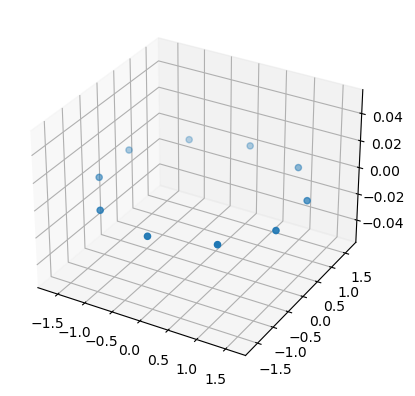

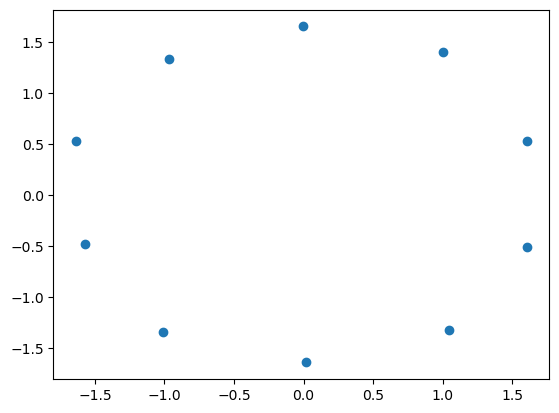

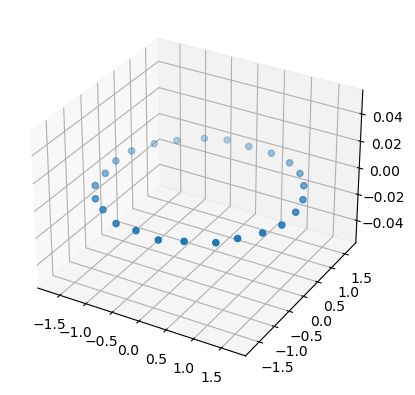

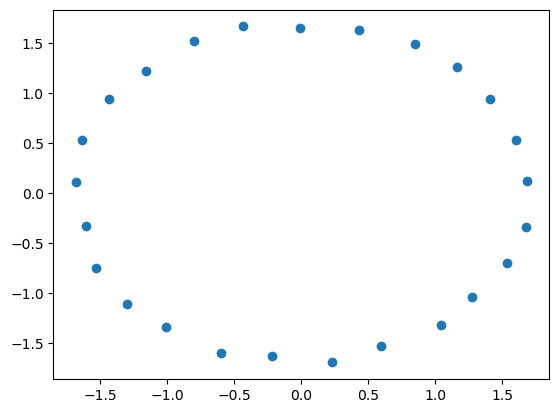

In [35]:
def xyz(t_m_arrays): # transform matrices np.array
    return t_m_arrays[:,0,3], t_m_arrays[:,1,3], t_m_arrays[:,2,3]

def xy(t_m_arrays): # transform matrices np.array
    return t_m_arrays[:,0,3], t_m_arrays[:,1,3]
def plot_filter(condition, labels, t_m_arrays):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    # ax.scatter(*xyz(t_m_arrays[outlier]), label=labels[1])
    # ax.scatter(*xyz(t_m_arrays[inlier]), label=labels[0])
    #ax.legend()
    ax.scatter(*xy(t_m_arrays))
    #fig.savefig(f"{out_ckpt_dir}/{scene}/{filename}")
    
    c2ws_filtered = t_m_arrays[inlier]
    
def plot_2d_filter(condition, labels, t_m_arrays):
    fig = plt.figure()
    ax = fig.add_subplot()
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    # ax.scatter(*xy(t_m_arrays[outlier]), label=labels[1])
    # ax.scatter(*xy(t_m_arrays[inlier]), label=labels[0])
    # ax.legend()
    #fig.savefig(f"{out_ckpt_dir}/{scene}/{filename}")
    ax.scatter(*xy(t_m_arrays))
    
def plot_3d(t_m_arrays):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(*xy(t_m_arrays))
    #fig.savefig(f"{out_ckpt_dir}/{scene}/{filename}")
        
def plot_2d(t_m_arrays):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(*xy(t_m_arrays))

ckpt_dir = "/home/ccl/Datasets/NeRF/ScanNerf"
#ckpt_dir = "../make_json_equator/json_equator"
#scene_list = sorted(os.listdir(path))
scene = "airplane1"

src_dir = f"{ckpt_dir}/{scene}"
    
src_json_path = f"{src_dir}/train_all.json"
dicts = get_dicts_from_json_path(src_json_path)
frames = dicts["frames"]

print(np.array([frame["transform_matrix"] for frame in frames])[:,:3, 3])
print(len(frames))

t_m_arrays = np.array([frame["transform_matrix"] for frame in frames])

equator_threshold = 0.4
for num_img in [10, 25]:
    selected_frames = get_horizontal_frames(frames, num_img)
    selected_t_m_arrays = np.array([frame["transform_matrix"] for frame in selected_frames]) # =~ c2ws?
    
    print(len(selected_t_m_arrays))
    #plot_filter(t_m_arrays[:,2,3] <= equator_threshold, ["equator", "not equator"], "equator_selection.jpeg", t_m_arrays)
    plot_3d(selected_t_m_arrays)
    plot_2d(selected_t_m_arrays)
